In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# 3. Fitting Circles

(2431, 2)


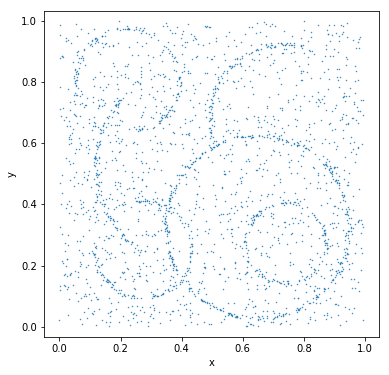

In [2]:
data = np.load('circles.npy')
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=0.2)
ax.axis('equal')
ax.set_xlabel('x'); ax.set_ylabel('y')
print(data.shape)

## 3.1 RANSAC

In [160]:
def circle_3point(p):
    A = np.array([[2 * (p[0,0]-p[1,0]), 2*(p[0,1]-p[1,1])],
                  [2 * (p[1,0]-p[2,0]), 2*(p[1,1]-p[2,1])]])
    b = np.array([p[0,0]**2 + p[0,1]**2 - p[1,0]**2 - p[1,1]**2,
                  p[1,0]**2 + p[1,1]**2 - p[2,0]**2 - p[2,1]**2])
    pc = np.linalg.solve(A, b)
    R = np.linalg.norm(p[0] - pc)
    return pc, R

In [161]:
def ransac_single(data, N, eps):
    center_best, r_best = np.zeros(2), 0
    inlier_count_best = 0
    eps2 = eps**2
    for _ in range(N):
        # select 3 random points and fit circle to it
        p_ind = np.random.randint(data.shape[0], size=3)
        try:
            center, r = circle_3point(data[p_ind])
        except np.linalg.LinAlgError:
            continue
        # find inliers
        dist2 = (data[:,0] - center[0])**2 + (data[:,1] - center[1])**2
        inliers = abs(dist2 - r**2) < eps2
        inlier_count = np.count_nonzero(inliers)
        if inlier_count > inlier_count_best:
            center_best, r_best = center, r
            inliers_best = inliers
            inlier_count_best = inlier_count
    if r_best == 0:
        return None, None, None
    else:
        return center_best, r_best, inliers_best

In [181]:
def ransac_multi(data, N_circles, N_ransac, eps, fit_circle=(lambda d,i,c,r:(c,r))):
    circles = []
    inlier_all = np.zeros(data.shape[0], dtype=bool)
    for _ in range(N_circles):
        center, r, inlier = ransac_single(data, N_ransac, eps)
        if r is None or inlier.shape[0] - np.count_nonzero(inlier) == 0:
            break
        circles.append(fit_circle(data, inlier, center, r))
        data = data[~inlier]
        inlier_all[~inlier_all] = inlier
    return circles, inlier_all

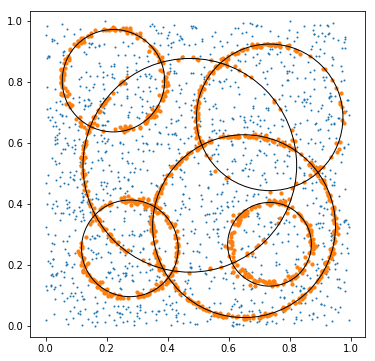

In [182]:
circles, inlier = ransac_multi(data, 6, N_ransac=10000, eps=0.07)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=1, label='All data')
ax.scatter(data[inlier,0], data[inlier,1], s=10, label='Outlier')
for center, r in circles:
    ax.add_patch(plt.Circle(center, r, fill=False))
ax.axis('equal');

## 3.2 Algebraic Distance

In [248]:
def algebraic_distance(data, inlier, c=None,r=None):
    # ggo to augmented space
    data = data[inlier]
    x = np.hstack((data, np.ones((data.shape[0],1))))
    y = np.sum(np.square(data), axis=1)
    beta = np.linalg.lstsq(x, y)[0]
    center = beta[:2] / 2
    r = np.sqrt(beta[2] + np.sum(np.square(center)))
    return center, r

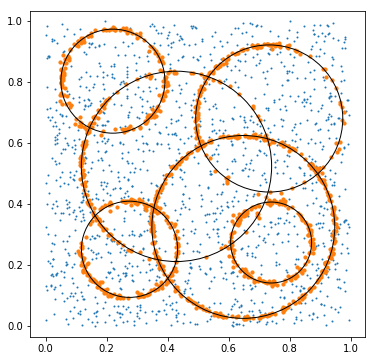

In [252]:
circles, inlier = ransac_multi(data, 6, N_ransac=10000, eps=0.07, fit_circle=algebraic_distance)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=1, label='All data')
ax.scatter(data[inlier,0], data[inlier,1], s=10, label='Outlier')
for center, r in circles:
    ax.add_patch(plt.Circle(center, r, fill=False))
ax.axis('equal');

## 3.3 Levenberg-Marquardt

In [ ]:
center, r, inlier = ransac_single(data, 10000, 0.07)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data[:,0], data[:,1], s=1, label='All data')
ax.scatter(data[inlier,0], data[inlier,1], s=10, label='Outlier')
ax.add_patch(plt.Circle(center, r, fill=False))
ax.add_patch(plt.Circle(*algebraic_distance(data, inlier), fill=False))
ax.axis('equal')
print(center, r)

## 3.4 Comparison